In [3]:
!pip install pycocotools
!pip install torch torchvision torchaudio

In [2]:
!git clone https://github.com/ultralytics/yolov5 
%cd yolov5
!pip install -r requirements.txt  

Cloning into 'yolov5'...
remote: Enumerating objects: 16982, done.
remote: Counting objects: 100% (177/177), done.
remote: Compressing objects: 100% (124/124), done.
remote: Total 16982 (delta 91), reused 109 (delta 53), pack-reused 16805 (from 1)
Receiving objects: 100% (16982/16982), 15.71 MiB | 32.50 MiB/s, done.
Resolving deltas: 100% (11620/11620), done.
/kaggle/working/yolov5
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 871.0/871.0 kB 23.1 MB/s eta 0:00:0000:01


In [5]:
import json
import os
from pycocotools.coco import COCO

def convert_coco_to_yolo(coco_json, img_dir, output_dir, max_categories=80):
    coco = COCO(coco_json)
    cat_ids = coco.getCatIds()
    categories = coco.loadCats(cat_ids)

    # Create a mapping from COCO category IDs to YOLO category IDs (0 to max_categories - 1)
    cat_id_map = {cat['id']: idx for idx, cat in enumerate(categories) if idx < max_categories}

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Convert each image
    for img_id in coco.getImgIds():
        img_info = coco.loadImgs(img_id)[0]
        img_file_name = img_info['file_name']
        img_width = img_info['width']
        img_height = img_info['height']

        # Convert annotations for this image
        ann_ids = coco.getAnnIds(imgIds=img_id)
        anns = coco.loadAnns(ann_ids)

        yolo_annotations = []
        for ann in anns:
            category_id = ann['category_id']
            if category_id in cat_id_map:
                yolo_category_id = cat_id_map[category_id]
                bbox = ann['bbox']
                x_center = (bbox[0] + bbox[2] / 2) / img_width
                y_center = (bbox[1] + bbox[3] / 2) / img_height
                width = bbox[2] / img_width
                height = bbox[3] / img_height

                yolo_annotations.append(f"{yolo_category_id} {x_center} {y_center} {width} {height}")

        # Save YOLO annotations
        txt_file_path = os.path.join(output_dir, img_file_name.replace('.jpg', '.txt'))
        with open(txt_file_path, 'w') as f:
            f.write('\n'.join(yolo_annotations))

    print(f"Annotations have been converted and saved to {output_dir}")

# Paths
coco_json = '/kaggle/input/coco-2017-dataset/coco2017/annotations/instances_train2017.json'
img_dir = '/kaggle/input/coco-2017-dataset/coco2017/train2017'
output_dir = '/kaggle/working/yolo_annotations'

convert_coco_to_yolo(coco_json, img_dir, output_dir)


loading annotations into memory...
Done (t=20.11s)
creating index...
index created!
Annotations have been converted and saved to /kaggle/working/yolo_annotations


In [6]:
import os
import shutil
import numpy as np
import time

def organize_dataset(img_dir, annotation_dir, output_dir, split_ratio=0.8):
    # List all annotation files
    annotations = [f for f in os.listdir(annotation_dir) if f.endswith('.txt')]

    if not annotations:
        print(f"No annotations found in {annotation_dir}. Check if the path and file extension are correct.")
        return

    # image files from annotations
    images = [f.replace('.txt', '.jpg') for f in annotations]

    np.random.shuffle(images)
    split_idx = int(len(images) * split_ratio)
    
    train_images = images[:split_idx]
    val_images = images[split_idx:]
    
    for subset in ['train', 'val']:
        os.makedirs(os.path.join(output_dir, subset, 'images'), exist_ok=True)
        os.makedirs(os.path.join(output_dir, subset, 'annotations'), exist_ok=True)

    start_time = time.time()
    
    for img_file in train_images[:100]: 
        shutil.copy(os.path.join(img_dir, img_file), os.path.join(output_dir, 'train', 'images', img_file))
        anno_file = img_file.replace('.jpg', '.txt')
        shutil.copy(os.path.join(annotation_dir, anno_file), os.path.join(output_dir, 'train', 'annotations', anno_file))
    
    for img_file in val_images[:100]: 
        shutil.copy(os.path.join(img_dir, img_file), os.path.join(output_dir, 'val', 'images', img_file))
        anno_file = img_file.replace('.jpg', '.txt')
        shutil.copy(os.path.join(annotation_dir, anno_file), os.path.join(output_dir, 'val', 'annotations', anno_file))
    
    elapsed_time = time.time() - start_time
    avg_time_per_file = elapsed_time / (100 * 2)  

    total_files = len(train_images) + len(val_images)
    estimated_total_time = avg_time_per_file * total_files

    print(f"Time for the first 100 files in each set: {elapsed_time:.2f} seconds")
    print(f"Estimated total time for all files: {estimated_total_time / 3600:.2f} hours")
    
    # Move all files
    for img_file in train_images:
        shutil.copy(os.path.join(img_dir, img_file), os.path.join(output_dir, 'train', 'images', img_file))
        anno_file = img_file.replace('.jpg', '.txt')
        shutil.copy(os.path.join(annotation_dir, anno_file), os.path.join(output_dir, 'train', 'annotations', anno_file))
    
    for img_file in val_images:
        shutil.copy(os.path.join(img_dir, img_file), os.path.join(output_dir, 'val', 'images', img_file))
        anno_file = img_file.replace('.jpg', '.txt')
        shutil.copy(os.path.join(annotation_dir, anno_file), os.path.join(output_dir, 'val', 'annotations', anno_file))

    print(f"Dataset split into training and validation sets with {len(train_images)} training images and {len(val_images)} validation images.")

# Paths
image_dir = '/kaggle/input/coco-2017-dataset/coco2017/train2017'
annotation_dir = '/kaggle/working/yolo_annotations'
output_dir = '/kaggle/working/split_dataset'

organize_dataset(image_dir, annotation_dir, output_dir)


Time for the first 100 files in each set: 1.68 seconds
Estimated total time for all files: 0.28 hours
Dataset split into training and validation sets with 94629 training images and 23658 validation images.


In [5]:
import os

def count_files(dir_path, file_extension):
    return len([f for f in os.listdir(dir_path) if f.endswith(file_extension)])

train_image_dir = '/kaggle/working/split_dataset/train/images'
val_image_dir = '/kaggle/working/split_dataset/val/images'
train_annotation_dir = '/kaggle/working/split_dataset/train/annotations'
val_annotation_dir = '/kaggle/working/split_dataset/val/annotations'

num_train_images = count_files(train_image_dir, '.jpg')
num_val_images = count_files(val_image_dir, '.jpg')
num_train_annotations = count_files(train_annotation_dir, '.txt')
num_val_annotations = count_files(val_annotation_dir, '.txt')

print(f"Training images: {num_train_images}")
print(f"Validation images: {num_val_images}")
print(f"Training annotations: {num_train_annotations}")
print(f"Validation annotations: {num_val_annotations}")

# Check if the counts match
assert num_train_images == num_train_annotations, "Mismatch between training images and annotations"
assert num_val_images == num_val_annotations, "Mismatch between validation images and annotations"


Training images: 94629
Validation images: 23658
Training annotations: 94629
Validation annotations: 23658


In [6]:
import os

def verify_annotations(annotation_dir, num_samples=5):
    annotation_files = [f for f in os.listdir(annotation_dir) if f.endswith('.txt')]

    for anno_file in annotation_files[:num_samples]:
        with open(os.path.join(annotation_dir, anno_file), 'r') as f:
            lines = f.readlines()
        print(f"Contents of {anno_file}:")
        for line in lines:
            print(line.strip())
        print()

verify_annotations(train_annotation_dir)
verify_annotations(val_annotation_dir)


Contents of 000000412525.txt:
7 0.1694609375 0.5007459207459207 0.299765625 0.4404662004662005

Contents of 000000139277.txt:
77 0.5505269320843091 0.510859375 0.8989461358313818 0.77978125
77 0.12798594847775174 0.34719531249999996 0.2559718969555035 0.43820312499999997

Contents of 000000334448.txt:
0 0.5364600550964188 0.1115234375 0.29991735537190084 0.223046875
20 0.4566528925619835 0.574328125 0.8179889807162535 0.8130625

Contents of 000000514456.txt:
29 0.46707031250000003 0.7824533333333333 0.055046874999999995 0.12885333333333335
60 0.8558359375 0.5684666666666667 0.061234374999999994 0.030586666666666668
60 0.73746875 0.54992 0.0365 0.005493333333333334
0 0.26465625 0.5420133333333333 0.46084375 0.7752800000000001
0 0.4373359375 0.5262133333333333 0.102671875 0.45232
0 0.5666718749999999 0.5990133333333333 0.07353125 0.20181333333333334
0 0.68078125 0.6475333333333333 0.05825 0.13485333333333333
0 0.7616093749999999 0.6213733333333333 0.10049999999999999 0.20136
0 0.97071093

In [7]:
def check_class_ids(annotation_dir):
    import glob

    txt_files = glob.glob(os.path.join(annotation_dir, '*.txt'))
    for txt_file in txt_files[:5]:  # Check first 5 files
        print(f"Contents of {txt_file}:")
        with open(txt_file, 'r') as f:
            print(f.read())

check_class_ids('/kaggle/working/split_dataset/train/annotations')
check_class_ids('/kaggle/working/split_dataset/val/annotations')


Contents of /kaggle/working/split_dataset/train/annotations/000000412525.txt:
7 0.1694609375 0.5007459207459207 0.299765625 0.4404662004662005
Contents of /kaggle/working/split_dataset/train/annotations/000000139277.txt:
77 0.5505269320843091 0.510859375 0.8989461358313818 0.77978125
77 0.12798594847775174 0.34719531249999996 0.2559718969555035 0.43820312499999997
Contents of /kaggle/working/split_dataset/train/annotations/000000334448.txt:
0 0.5364600550964188 0.1115234375 0.29991735537190084 0.223046875
20 0.4566528925619835 0.574328125 0.8179889807162535 0.8130625
Contents of /kaggle/working/split_dataset/train/annotations/000000514456.txt:
29 0.46707031250000003 0.7824533333333333 0.055046874999999995 0.12885333333333335
60 0.8558359375 0.5684666666666667 0.061234374999999994 0.030586666666666668
60 0.73746875 0.54992 0.0365 0.005493333333333334
0 0.26465625 0.5420133333333333 0.46084375 0.7752800000000001
0 0.4373359375 0.5262133333333333 0.102671875 0.45232
0 0.5666718749999999 0

In [8]:
import shutil

source_path = '/kaggle/input/cocoyaml/coco.yaml'
destination_path = '/kaggle/working/yolov5/data/coco.yaml'

shutil.copy(source_path, destination_path)

print(f"Copied {source_path} to {destination_path}")


Copied /kaggle/input/cocoyaml/coco.yaml to /kaggle/working/yolov5/data/coco.yaml


In [11]:
rm /kaggle/working/split_dataset/train/labels.cache


rm: cannot remove '/kaggle/working/split_dataset/train/labels.cache': No such file or directory


In [12]:
import os

def check_image_annotation_match(img_dir, ann_dir):
    # Get list of image files
    img_files = [f for f in os.listdir(img_dir) if f.endswith('.jpg')]
    img_files = set([os.path.splitext(f)[0] for f in img_files])  # Strip extensions
    
    # Get list of annotation files
    ann_files = [f for f in os.listdir(ann_dir) if f.endswith('.txt')]
    ann_files = set([os.path.splitext(f)[0] for f in ann_files])  # Strip extensions

    # Check for images with missing annotations
    missing_ann = img_files - ann_files
    if missing_ann:
        print(f"Images without annotations: {missing_ann}")

    # Check for annotations with missing images
    missing_img = ann_files - img_files
    if missing_img:
        print(f"Annotations without images: {missing_img}")

    if not missing_ann and not missing_img:
        print("All images have corresponding annotations and vice versa.")

# Paths
img_dir = '/kaggle/input/coco-2017-dataset/coco2017/train2017'
ann_dir = '/kaggle/working/yolo_annotations'

check_image_annotation_match(img_dir, ann_dir)


All images have corresponding annotations and vice versa.


In [13]:
ls -l /kaggle/working/split_dataset


total 8
drwxr-xr-x 4 root root 4096 Sep 24 08:44 train/
drwxr-xr-x 4 root root 4096 Sep 24 08:44 val/


In [8]:
!python /kaggle/working/yolov5/train.py --img-size 640 --batch-size 16 --epochs 14 --data /kaggle/input/cocoyaml/coco.yaml --weights yolov5s.pt --device 0


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice: (30 second timeout) 
wandb: W&B disabled due to login timeout.
train: weights=yolov5s.pt, cfg=, data=/kaggle/input/cocoyaml/coco.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=14, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, no

In [9]:
!python detect.py --weights /kaggle/input/best-test/best.pt --source /kaggle/input/cartest123/cattest.jpg --img 640 --conf 0.25



detect: weights=['/kaggle/input/best-test/best.pt'], source=/kaggle/input/cartest123/cattest.jpg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_format=0, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-372-ga3555241 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)

Fusing layers... 
Model summary: 157 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
image 1/1 /kaggle/input/cartest123/cattest.jpg: 448x640 9 cars, 31.6ms
Speed: 0.5ms pre-process, 31.6ms inference, 138.9ms NMS per image at shape (1, 3, 640, 640)
Results saved to runs/detect/exp


In [7]:
!mv /kaggle/working/split_dataset/train/annotations /kaggle/working/split_dataset/train/labels
!mv /kaggle/working/split_dataset/val/annotations /kaggle/working/split_dataset/val/labels


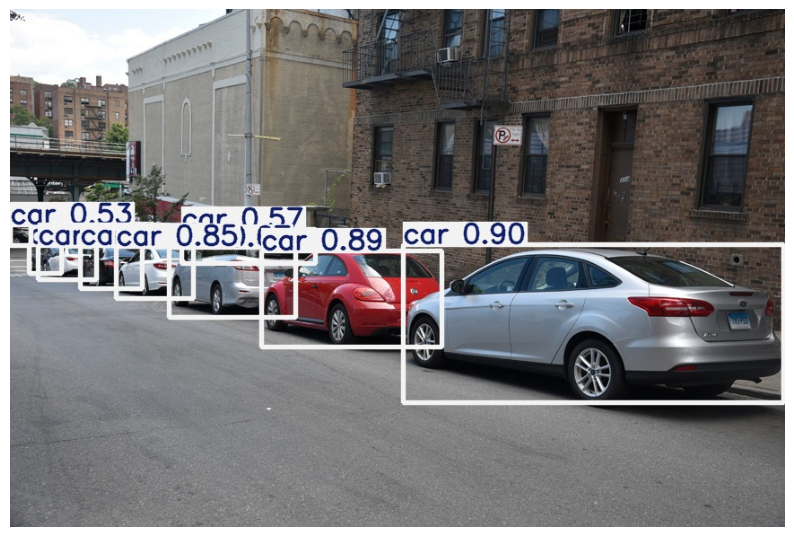

In [10]:
import cv2
from matplotlib import pyplot as plt

# Path to the image
image_path = '/kaggle/working/yolov5/runs/detect/exp/cattest.jpg'

# Load the image using OpenCV
img = cv2.imread(image_path)

# Convert BGR to RGB (OpenCV loads images in BGR format by default)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Display the image
plt.figure(figsize=(10, 10))
plt.imshow(img_rgb)
plt.axis('off')  # Hide axes
plt.show()


In [2]:
pip install huggingface_hub


Note: you may need to restart the kernel to use updated packages.


In [1]:
!pip install torch torchvision transformers
